In [3]:
from __future__ import print_function
import glob, itertools, os, subprocess, re
import sys, time, tqdm, itertools, random
import mdtraj as md
import numpy as np
from itertools import groupby, count
import matplotlib, msmbuilder
%matplotlib inline
# Script: matplotlib.use('Agg')  | Notebook: %matplotlib inline
from matplotlib import pyplot as plt
from msmbuilder.cluster import KCenters, KMeans, KMedoids
from msmbuilder.decomposition import tICA
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.msm import MarkovStateModel
from msmbuilder.msm.core import *
from pyemma.thermo.util import get_averaged_bias_matrix as _get_averaged_bias_matrix
import pyemma

'''This script has lots of functionality and is based on analyzing Gromacs trajectories. A list of trajectory
   files is given as trajectory_files, as well as a general structure file. Other structure files should contain
   the same name as the corresponding trajectory file, e.g. traj_001.trr traj_001.gro. e.g.:
   ../projects/
       Gromacs/
           p14137/
               {npt.gro,index.ndx,topol.top,...}
   ../PROJ14137/ # raw data directory
       RUN0/
           CLONE0/
               results0/
   ../analysis/
       analysis.ipynb (YOU ARE HERE)
       PROJ14137/
           traj_data/
               RUN0/
                   P14101_R0_C0.xtc ...(These are PBC-corrected trajectories)
            xtc.gro (This is the gro file used to load in all traj_data files)
'''

# this project represents a spiroligomer (1) from https://doi.org/10.1371/journal.pone.0045948
# bound to MDM2 (PDB: 1ycr)
# these runs represent the 20 ensembles: lam = false, d = {0.1, 2.0, 0.1}

# featurization parameters
project_title = 'PROJmacro' # creates sub-directory
structure_file = f'{project_title}/xtc.gro'
runs = len(glob.glob(f'{project_title}/traj_data/RUN*'))
clones = max([len(glob.glob(f'{project_title}/traj_data/RUN{x}/*')) for x in range(runs)])
md_time_step = 0.02 # time in ns that trajectory files are saved (nstxtcout)
equil_time = 1. # time in ns to remove from beginning of each clone
subsampled_time_step = 0.5 # preferred subsampled time-step in ns
stride = int(subsampled_time_step / md_time_step) # time step stride for sub-sampling
equil_steps = int(equil_time / md_time_step) # time steps to be removed from start
custom_residues = ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A'] # for spiroligomers
custom_residues += ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN'] # for nutlins

# tICA/MSM parameters
unbiased_runs = [20]
tica_lagtime = 10 # determine from implied timescales / GMRQ
n_components = 8 # how many tICs to compute
n_clusters = 50 # denotes number of microstates
n_timescales = n_components # plot all eigenvalues --> timescales
lagtimes = np.array([1,2,4,8,16,32,64,128,256,512,1024]) # log scale
cluster_method = 'kcenters' # 'kcenters/kmeans/kmedoids'
all_ticas = list(itertools.permutations(range(1,n_components+1), 2)) # all combinations
all_ticas = [[1,2],[1,3],[2,3]] # override: just show analysis for first three components
cluster_percentage_cutoff = n_clusters/64 # clusters with a relative population less than this
                              # number will not be labeled on plot i.e. 0 : all clusters labeled

# MBAR/TRAM parameters
K = runs # sets n_ensembles = n_runs
L = K # secondary ensemble count for MBAR
kspring_k = [200.]*20 + [0] # spring constant for each ensemble in kJ/mol/nm^2
equilibrium_distances = [0.1+0.1*k for k in range(K)]
protein_anchor = 555
restrained_distance_indices = [[[555,'COM']]]*K # which distances are restrained for each
restrained_distance_labels = ['d555-ligand_COM']*K # restraint labels for plots
temperature = 300.0 # in K
T_k = np.ones(K,float)*temperature # This simulation uses only 300K sampling
kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))

print(f'Current Directory: {os.getcwd()}')
print('\nContents:')

%ls

Current Directory: /media/matt/ext/projects/macrocycles

Contents:
both_macrocycle/  h030_natfl_water/   old_h030/
complete_model/   H031_DFT/           PROJmacro/
en-pro-jd1.docx   JD_Macrocycles.cdx  spiroligomer_analysis-Copy1.ipynb*
h030_fep/         macrocycle          spiroligomer_analysis.ipynb*
h030_ktfl_water/  naktfl_pics/        VAMPnets.ipynb*
h030natfl_pics/   oldd_h030_tica/


In [2]:
def compute_distances():
    
    """Calculate pair-wise distance features and save as .npy files.
       Index selection is done within the function.
       Feature labels are returned to match tICA components back to the features that make them up.
    """
    
    print("\nCalculating distances...")
    
    if not os.path.exists(project_title + '/features'):
        os.mkdir(project_title + '/features')
    
    verbose = False
    protein_residues = range(50,64) # residue indices for MDM2 binding helix
    trajectory_files = []
    skipped = 0
    
    for run in range(runs):
        trajectory_files += sorted(glob.glob('%s/traj_data/RUN%d/*xtc'%(project_title,run)))

    for i in tqdm.tqdm_notebook(range(len(trajectory_files))): # For each trajectory file
        traj = md.load(trajectory_files[i], top=structure_file)
        if verbose:
            print("Loaded " + trajectory_files[i] + " with top: " + structure_file)

        # custom residue definition
        custom_residues = ['1MQ','20Q','20U','I18','I31','NUT','YIN','K23']
        custom_residues += ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
        custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A']

        # index selection
        protein_indices = [ a.index for a in traj.topology.atoms if a.name in ['CA'] and a.residue.index in protein_residues and a.residue.name not in custom_residues]
        ligand_indices = [ a.index for a in traj.topology.atoms if a.element.symbol == 'C' and a.residue.name in custom_residues]

        # transform indices into distances and save
        pairs = list(itertools.product(protein_indices[::2], ligand_indices[::3]))
        
        # ensure that number of features is greater than the length of the strided
        # trajectory, so the autocorrelation matrix is guaranteed to be positive definite.
        if len(pairs) > len(traj[equil_steps:][::stride]):
            if verbose:
                print("Number of features (%d) exceeds strided trajectory length (%d). Skipping.\n" %(len(pairs),len(traj)/stride))
            skipped += 1
            continue
        
        # these are returned and are useful for mapping tICA components back to the 
        # atoms and residues that correspond to each feature.
        feature_labels = [[[str(traj.topology.atom(j[0]).residue.index) +
                            traj.topology.atom(j[0]).residue.name,traj.topology.atom(j[0]).name],
                          [str(traj.topology.atom(j[1]).residue.index) + 
                           traj.topology.atom(j[1]).residue.name,traj.topology.atom(j[1]).name]] for j in pairs]
        np.save('%s/feature_labels.npy'%project_title, labels)
        
        features = AtomPairsFeaturizer(pairs)
        transformed_data = features.fit_transform(traj[equil_steps:][::stride])
        
        for j in range(len(transformed_data)):
            transformed_data[j] = transformed_data[j][0]
        
        if verbose:
            print("Saved %d pair-wise distance features over %d frames.\n" %(
                len(pairs),len(transformed_data)))
        feature_file = re.sub('.xtc','',re.sub('traj_data/RUN.*/','features/',trajectory_files[i]))
        np.save(feature_file, transformed_data)
    
    print('Skipped %d/%d (%.3f%%) trajectories because number of features exceeded strided frames.'%(skipped,len(trajectory_files),float(100*skipped/len(trajectory_files))))
    print('If this number seems too high, decrease number of features or decrease stride.')
    
    return feature_labels

In [17]:
def training_validation_split(training_percentage):
    
    '''returns lists of .npy files for training and validation that use equal amounts of 
    each run/ensemble according to a given training_percentage'''
    
    training_set, validation_set = [],[]
    for i in range(runs):
        feature_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
        features = [ np.load(filename) for filename in feature_files ]
        n_training_frames = len(np.concatenate(features)) * (training_percentage/100)
        cumulative_frames = 0
        for j in range(len(features)):
            if cumulative_frames < n_training_frames:
                training_set.append(feature_files[j])
                cumulative_frames += len(features[j])
            else:
                validation_set.append(feature_files[j])

    training_frames = len(np.concatenate([np.load(filename) for filename in training_set]))
    validation_frames = len(np.concatenate([np.load(filename) for filename in validation_set]))
    print('Training percentage: %.3f of requested %d'%((training_frames*100/(
        validation_frames+training_frames), training_percentage)))
    random.shuffle(training_set)
    random.shuffle(validation_set)

    return training_set, validation_set

def bootstrap_split():
    '''Return a shuffled list of feature file indices to be used in boot-strapping MSM or TRAM
       calculations. The list for each ensemble is of the same length as the number of trajectories
       normally found for that ensemble.'''
    bootstrap_indices = []
    for k in range(runs):
        bootstrap_indices.append([])
        n_featurefiles = len(glob.glob('%s/features/*_R%d_*npy'%(project_title,k)))
        for l in range(n_featurefiles):
            bootstrap_indices[k].append(random.randint(0,n_featurefiles-1))
    return bootstrap_indices

In [6]:
def compute_tica_components():
          
    '''Load in the features, calculate a given number of tICA components (tica_components) given a
       lagtime (lag_time), and save tICA coordinates and eigenvector data. It then creates and populates
       a list for each desired component, clusters the data, saving normalized populations as populations.dat
       and saving each cluster center as a .pdb. tICA plots are created and saved, and implied timescales are
       calculated, saved, and plotted.
    '''
        
    verbose = False
    save_pdb = True
    color_by = 'cluster'
    
    if verbose:
        print("\nCalculating tICA components...")
    if not os.path.exists(project_title + '/tica_%d_%d'%(n_clusters, count)):
        os.mkdir(project_title + '/tica_%d_%d'%(n_clusters, count))
    
    # load in feature files and determine indices of unbiased ensembles
    feature_files = []
    for i in range(runs):
        run_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
        feature_files += run_files
        if i in unbiased_runs:
            unbiased_indices = [len(feature_files) - len(run_files),len(feature_files)]
    features = [np.load(x) for x in feature_files]
    
    # perform tICA calculation and extract score / eigenvectors
    tica_coordinates = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit_transform(features)
    tica_components = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit(features)
    eigenvectors = np.transpose(tica_components.eigenvectors_)
    tica_score = tica_components.score(features)
          
    np.save('%s/tica_%d_%d/tica_coords-lag_%d-comp_%d.npy' %(
        project_title, n_clusters, count, tica_lagtime, n_components), tica_coordinates)
    np.save('%s/tica_%d_%d/tica_comps-lag_%d-comp_%d.npy' %(
        project_title, n_clusters, count, tica_lagtime, n_components), tica_components)
    
    # Perform clustering based on the cluster_method parameter.
    if verbose:
        print('Clustering via %s'%cluster_method)
    if cluster_method == 'kcenters':
        clusters = KCenters(n_clusters)
    elif cluster_method == 'kmeans':
        clusters = KMeans(n_clusters)
    elif cluster_method == 'kmedoids':
        clusters = KMedoids(n_clusters)
    else:
        sys.exit('Invalid cluster_method. Use kcenters/kmeans/kmedoids.')
        
    # Cluster unbiased data and fit biased data to these centers
    new_assignments = []
    sequences = clusters.fit_transform(tica_coordinates[unbiased_indices[0]:unbiased_indices[1]])
    for i in tqdm.tqdm_notebook(range(unbiased_indices[0])):
        tica_traj = tica_coordinates[i]
        if isinstance(tica_traj, np.ndarray):
            if not (tica_traj.dtype == 'float32' or tica_traj.dtype == 'float64'):
                tica_traj = tica_traj.astype('float64')
        labels, inertia = msmbuilder.libdistance.assign_nearest(
            tica_traj, clusters.cluster_centers_, metric='euclidean')
        new_assignments.append(labels)

    new_assignments += sequences # tack the unbiased assignments back on to the end.


    np.save('%s/tica_%d_%d/lag_%d_clusters_%d_assignments.npy' %(
        project_title, n_clusters, count, tica_lagtime, n_clusters), new_assignments)
    np.save('%s/tica_%d_%d/lag_%d_clusters_%d_center.npy' %(
        project_title, n_clusters, count, tica_lagtime, n_clusters), clusters.cluster_centers_)

    # Determine cluster populations, normalize the counts, and save as percentages for
    # labeling if a cluster contains more than cluster_percentage_cutoff percent of the data.
    # Finally, save normalized counts.
    
    if verbose:
        print("\nDetermining cluster populations...")
    if not os.path.exists('%s/tica_%d_%d/%s_clusters'%(project_title,n_clusters,count,cluster_method)):
        os.mkdir('%s/tica_%d_%d/%s_clusters'%(project_title,n_clusters,count,cluster_method))
    if not os.path.exists('%s/tica_%d_%d/plots'%(project_title,n_clusters, count)):
        os.mkdir('%s/tica_%d_%d/plots'%(project_title,n_clusters,count))
        
    counts = np.array([len(np.where(np.concatenate(sequences)==i)[0]) for i in range(n_clusters)])
    normalized_counts =  counts/float(counts.sum())
    percentages = [ i*100 for i in normalized_counts ]
    population_labels = [ [i,"%.2f"%percentages[i]] for i in range(len(percentages)) if percentages[i] > cluster_percentage_cutoff ]
    np.savetxt('%s/tica_%d_%d/%s_clusters/populations.dat'
               %(project_title,n_clusters,count,cluster_method), normalized_counts)

    # Plot all unique combinations of tICA components
    if verbose:
        print("\nPlotting tICA components...")
    tica_coordinates = np.concatenate(tica_coordinates)
    new_assignments = np.concatenate(new_assignments)
    cluster_colors = matplotlib.cm.rainbow(np.linspace(0,1,n_clusters))
    for j in tqdm.tqdm_notebook(range(len(all_ticas)),leave=False): # For each pair
        if all_ticas[j][0] < all_ticas[j][1]:
            plt.figure(j, figsize=(20,16))
            tICx, tICy = all_ticas[j][0]-1, all_ticas[j][1]-1
            plt.hexbin(tica_coordinates[:,tICx],tica_coordinates[:,tICy], bins='log')
            for l in tqdm.tqdm(range(len(tica_coordinates))[::stride*2]):
                if color_by == 'cluster':
                    plt.plot(tica_coordinates[l][tICx], tica_coordinates[l][tICy],
                        color=cluster_colors[new_assignments[l]], linestyle="", marker="o")
            x_centers = [clusters.cluster_centers_[i][tICx] for i in range(len(clusters.cluster_centers_))]
            y_centers = [clusters.cluster_centers_[i][tICy] for i in range(len(clusters.cluster_centers_))]
            high_pop_x_centers = [ x_centers[i] for i in range(len(x_centers)) if percentages[i] > cluster_percentage_cutoff ]
            high_pop_y_centers = [ y_centers[i] for i in range(len(y_centers)) if percentages[i] > cluster_percentage_cutoff ]
            plt.plot(x_centers, y_centers, color='y', linestyle="", marker="o")
            plt.plot(tica_coordinates[:,tICx][0],tica_coordinates[:,tICy][0], color='k', marker='*',markersize=24)
            plt.xlabel('tIC'+str(all_ticas[j][0]))
            plt.ylabel('tIC'+str(all_ticas[j][1]))
            plt.title(project_title)
            # Add labels for high-population cluster centers
            for label, x, y in zip(population_labels, high_pop_x_centers, high_pop_y_centers):
                plt.annotate(
                  label,
                  xy = (x, y), xytext = (-15, 15),
                  textcoords = 'offset points', ha = 'right', va = 'bottom',
                  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            plt.savefig('%s/tica_%d_%d/plots/tica_%d_%d.png'%(project_title,n_clusters,
                count,all_ticas[j][0], all_ticas[j][1]))
            plt.close()

    # Write out PDBs for each cluster center
    if verbose:
        print("Performing cluster analytics and saving center PDBs...\n")
    if save_pdb:
        trajectory_files, feature_files, cluster_features = [],[],[]
        for run in [20]: #range(runs): # get only xtc files that correlate to cluster-center features
            trajectory_files += [re.sub('features',
                                    'traj_data/RUN%d'%run,re.sub('npy','xtc',x)
                                     ) for x in sorted(glob.glob('%s/features/*R%d_*npy'%(
                                        project_title,run)))]
            feature_files += sorted(glob.glob('%s/features/*R%d_*npy'%(project_title,run)))

        for i in tqdm.tqdm_notebook(range(len(trajectory_files)),leave=False):

                n_snapshots = len(clusters.distances_[i])

                # Determine frames that are cluster centers
                cluster_indices = np.arange(n_snapshots)[ (clusters.distances_[i] < 1e-6) ]

                # Determine number of each cluster, correlates to populations.dat
                cluster_labels = sequences[i][cluster_indices]

                # Save each cluster center as a pdb
                if list(cluster_indices): # load center-containing xtcs to check length
                    xtc_len = len(md.load(trajectory_files[i],top=structure_file))
                    
                # map strided frame number back to xtc frame number
                for j in range(len(cluster_indices)):
                        frames = range(xtc_len) 
                        strided_frames = frames[equil_steps:][::stride]
                        xtc_frame = frames.index(strided_frames[cluster_indices[j]])
                        cluster_traj = md.load_frame(trajectory_files[i], xtc_frame,
                                            top=structure_file)
                        cluster_features.append(np.load(feature_files[i])[cluster_indices[j]])
                        cluster_traj.save_pdb('%s/tica_%d_%d/%s_clusters/state_%d.pdb'
                                            %(project_title,n_clusters,count,cluster_method,
                                            cluster_labels[j]))
                        
                        # save cluster information
                        with open('%s/tica_%d_%d/cluster.dat'%(project_title,n_clusters,count),'w') as f:
                            f.write('\nSuccessfully saved PDB for cluster: %d, (rel.pop: %.3f)'%(
                                cluster_labels[j],percentages[cluster_labels[j]]))
                            f.write('traj_file: %s (%d/%d)'%(trajectory_files[i],i,len(features)))
                            f.write('frame: %d (%d/%d centers from this trajectory)'%(
                                cluster_indices[j],j,len(cluster_indices)))
                            f.write('strided: npy_frame/npy_len = %d/%d = %f'%(
                                cluster_indices[j],n_snapshots,cluster_indices[j]/n_snapshots))
                            f.write('re-mapped: orig_frame/xtc_len = %d/%d = %f\n'%(
                                xtc_frame,xtc_len,xtc_frame/xtc_len))
                            f.close()
                        
        # save features corresponding to each cluster center
        np.save('%s/tica_%d_%d/cluster_features.npy'%(project_title,n_clusters,count),cluster_features)
                    
    return tica_score

count = 0
compute_tica_components()

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [5]:
def compute_center_of_mass(traj, atom_indices=None):
    
    """
    https://github.com/mdtraj/mdtraj/pull/1135/commits/5013df4b1e60c2f10cdcfd59bdcbc5183d38e608
    Compute the center of mass for each frame.
    Parameters:
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    atom_indices : list of int
        Atoms to compute center of mass for. If None,
        will compute over all atoms
    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    if atom_indices is None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)

    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in traj.top.atoms])
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()

    #for i, x in enumerate(traj.xyz):
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
        
    return com

In [6]:
def compute_restraint_distances():
    
    """Computes un-(strided/equilibrated) umbrella restraint distances and 
       saves a numpy.savetxt(shape=(num_conf_states(frames),3)) 
       for each run, saving clone and timestep and distance for each frame."""
    
    print('\nComputing restraint distances...')
    distances_path = project_title + '/umbrella_distances'
    if not os.path.exists(distances_path):
        os.mkdir(distances_path)

    for k in tqdm.tqdm_notebook([20]): #range(K)):
        f = open('%s/run_%d_dists.dat'%(distances_path,k),'w')
        f.write('#clone\ttime(ns)\t%s\n'%restrained_distance_labels[k])

        traj_files = [re.sub('npy','xtc',re.sub('features','traj_data/RUN%d'%k,x)) for x in sorted(glob.glob(
            '%s/features/P*R%d_*npy'%(project_title,k)))]
        reordered_clones = [re.sub('.*C','',re.sub('.xtc','',x)) for x in traj_files]
                                              
        for j in range(len(traj_files)):
            traj = md.load(traj_files[j], top=structure_file)
            ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
            ligand_COM = compute_center_of_mass(traj,ligand_indices)
            protein_xyz = np.take(traj.xyz, [protein_anchor], axis=1)

            for k in range(len(traj)):
                    distance_between_groups = np.sqrt(
                        (ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                        (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                        (ligand_COM[k][2] - protein_xyz[k][0][2])**2)

                    f.write('%s\t%f\t%f\n'%(reordered_clones[j],0.1+ 0.1*k,distance_between_groups))
        f.close()

In [19]:
def compute_dtraj():
    
    """Computes dtraj object for use in TRAM. Returns and saves a 
       numpy.ndarray(shape=(num_therm_states(runs), num_conf_states(frames)))
       that contains the cluster assignment index for each frame of trajectory data."""
    
    print("\nComputing and saving dtraj object...")
    dtraj = []
    
    # populate dtram object with assignments saved during tICA computation.
    # the input for tICA was already trimmed for equilibration and strided
    # so we need not do that here.

    assignments_file = '%s/tica_%d_%d/lag_%d_clusters_%d_assignments.npy'%(
        project_title,n_clusters,bootstrap_count,tica_lagtime,n_clusters)
    assignments = np.load(assignments_file, allow_pickle=True)
    
    for i in assignments:
        dtraj.append(i)
        
    np.save('%s/pyemma_%d/dtraj.npy'%(project_title,n_clusters),dtraj)
    return dtraj


def compute_btraj():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))"""
    
    print('\nComputing and saving btraj object...')
    btraj = []
    
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]

    for k in tqdm.tqdm_notebook(range(K)):
        reordered_clones = [int(re.sub('.*C','',re.sub('.npy','',x))) for x in sorted(
            glob.glob(project_title + '/features/P*R%s_*'%k))]

        for clone in reordered_clones:
            frame_reduced_potentials = []
            clone_distances = np.asarray([distances[k][x][2] for x in range(len(distances[k])) if distances[k][x][0] == clone])

            for l in range(L):
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(clone_distances - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(clone_distances - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k

                if k in unbiased_runs: # no bias for unbiased runs
                    reduced_potential_for_k_at_l = [0.]*len(reduced_potential_for_k_at_l)

                frame_reduced_potentials.append(reduced_potential_for_k_at_l)
            btraj.append(np.transpose(frame_reduced_potentials))
            
    np.save('%s/pyemma_%d/btraj.npy'%(project_title,n_clusters), btraj)
    return btraj


def compute_ttraj():
    
    """Computes the index of the thermodynamic state (ensemble) for each trajectory frame.
       In FAH cases, this is usually just the run. Returns and saves a
       numpy.ndarray(shape=(N_traj,num_uncorr_samples(sum_frames/traj)))"""

    print('\nComputing and saving ttraj object...')
    ttraj = []
    
    for i in range(runs):
        feature_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*.npy"%i))
        features = [ np.load(filename) for filename in feature_files]
        for j in range(len(features)):
            ttraj.append(np.asarray([i]*features[j].shape[0]))
        
    np.save('%s/pyemma_%d/ttraj.npy'%(project_title,n_clusters),ttraj)
    return ttraj       
        

In [8]:
def compute_ukn():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))
       This format is used for pymbar input."""
    
    print('\nComputing and saving u_kn object...')
    if not os.path.exists(project_title + '/mbar'):
        os.mkdir(project_title + '/mbar')
    
    no_equilibrium_samples = True
    
    u_kn = []
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]
    N_k = [x.shape[0] for x in distances]
    
    for k in tqdm.tqdm_notebook(range(K)):
        u_kn.append([])
        
        for l in range(L):
            if k == l:
                for m in range(len(distances[k])):
                    u_kn[k].append(0)

            else:
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(distances[l][:,2] - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(distances[l][:,2] - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k
                
                for m in reduced_potential_for_k_at_l:
                    u_kn[k].append(m)
    
    if no_equilibrium_samples:
        N_k.append(0)
        u_kn.append([0]*np.sum(N_k))
    
    u_kn = np.asarray(u_kn)
    np.save(project_title + '/mbar/u_kn.npy', u_kn)
    return u_kn, N_k

In [8]:
def prepare_pyemma_objects():

    """Loads in btraj, dtraj, and ttraj objects if they exist. Computes them from above
       functions if they do not. Returns btraj, dtraj, ttraj as lists of np.arrays."""
    
    verbose = False
    bootstrap = True
    structure_file = '%s/xtc.gro'%project_title
    
    if verbose:
        print('\n\n#################### %s #####################'%project_title)
            
    btraj = compute_btraj()
    dtraj = compute_dtraj()
    ttraj = compute_ttraj()
    
    if verbose:
        print('BTRAJ:')
        print('np.shape(btraj): ',np.shape(btraj))
        print('np.shape(btraj)[0]: ',np.shape(btraj[0]))
        print('DTRAJ:')
        print('np.shape(dtraj): ',np.shape(dtraj))
        print('np.shape(dtraj[0]): ',np.shape(dtraj[0]))
        print('TTRAJ:')
        print('np.shape(ttraj): ',np.shape(ttraj))
        print('np.shape(ttraj[0]): ',np.shape(ttraj[0]))

    # some btraj sequences are one frame longer, so we trim them.
    for i in range(len(btraj)):
        while np.shape(ttraj[i])[0] != np.shape(btraj[i])[0]:
            btraj[i] = np.asarray(np.ndarray.tolist(btraj[i])[0:-1])
            
    if bootstrap: # randomly split the data vida bootstrapping
        btraj_, dtraj_, ttraj_ = [],[],[]
        bootstrap_indices = bootstrap_split()
        for k in range(runs):
            k_indices = []
            for l in range(len(ttraj)):
                if k == ttraj[l][0]:
                    k_indices.append(l)

            bootstrap_k_indices = [k_indices[x] for x in bootstrap_indices[k]]
            btraj_ += [btraj[x] for x in bootstrap_k_indices]
            dtraj_ += [dtraj[x] for x in bootstrap_k_indices]
            ttraj_ += [ttraj[x] for x in bootstrap_k_indices]
        btraj, dtraj, ttraj = btraj_, dtraj_, ttraj_
    
    return btraj, dtraj, ttraj

In [ ]:
def compute_msm():
    
    verbose = False
    if not os.path.exists('%s/msm_%d'%(project_title,n_clusters)):
        os.mkdir('%s/msm_%d'%(project_title,n_clusters))
        
    lagsteps = [x/subsampled_time_step for x in lagtimes]
    btraj, dtraj, ttraj = prepare_pyemma_objects()
    print('\nCreating MSM with lagtimes:',lagtimes)
    
    msm_obj = pyemma.msm.estimate_markov_model(dtraj, lag=100, reversible=True, statdist=None,
                        count_mode='sliding', weights='empirical', sparse=False, 
                        connectivity='largest', dt_traj='%f ns'%subsampled_time_step, maxiter=1000000,
                        maxerr=1e-08, score_method='VAMP2', score_k=10,
                        mincount_connectivity='1/n')
    
    if verbose:
        print('\nRaw MSM:')
        print(msm_obj)
    
    msm_obj.save('%s/msm_%d/model.emma'%(project_title,n_clusters),overwrite=True)
    np.save('%s/msm_%d/transition_matrix.npy'%(project_title,n_clusters),
            msm_obj.transition_matrix)
    np.save('%s/msm_%d/stat_dist.npy'%(project_title,n_clusters),
            msm_obj.stationary_distribution)

    msm_plots('MSM',msm_obj)
            

def compute_tram():
    
    verbose = False
    if not os.path.exists('%s/tram_%d_%d'%(project_title,n_clusters, bootstrap_count)):
        os.mkdir('%s/tram_%d_%d'%(project_title,n_clusters, bootstrap_count))
    
    lagsteps = [x/subsampled_time_step for x in lagtimes]
    btraj, dtraj, ttraj = prepare_pyemma_objects()    
    print('\nRunning TRAM with lagtimes:',lagtimes)
    
    tram_obj = pyemma.thermo.tram(ttraj, dtraj, btraj, lag=100, unbiased_state=unbiased_runs[0],
                           count_mode='sliding', connectivity='post_hoc_RE', maxiter=100000,
                            maxerr=1e-15, save_convergence_info=1000, dt_traj='%f ns'%subsampled_time_step, 
                           connectivity_factor=1.0, nn=None, direct_space=True,
                           N_dtram_accelerations=1, callback=None, init='mbar', 
                           init_maxiter=10000, init_maxerr=1e-08, equilibrium=None,
                           overcounting_factor=1.0)
    if verbose:
        print('\nTRAM MSM:')
        print(tram_obj.msm)
    
    tram_obj.save('%s/tram_%d_%d/model.emma'%(project_title,n_clusters, bootstrap_count),overwrite=True)
    np.save('%s/tram_%d_%d/log_likelihood.npy'%(project_title,n_clusters, bootstrap_count),
            tram_obj.log_likelihood())
    np.save('%s/tram_%d_%d/transition_matrix.npy'%(project_title,n_clusters, bootstrap_count),
            tram_obj.msm.transition_matrix)
    np.save('%s/tram_%d_%d/stat_dist.npy'%(project_title,n_clusters, bootstrap_count),
            tram_obj.stationary_distribution)
    np.save('%s/tram_%d_%d/free_energies.npy'%(project_title,n_clusters, bootstrap_count),
            tram_obj.free_energies)
    
    msm_plots('TRAM',tram_obj.msm)
    
    
def compute_dtram():
    
    verbose = False
    if not os.path.exists('%s/dtram_%d'%(project_title,n_clusters)):
        os.mkdir('%s/dtram_%d'%(project_title,n_clusters))
    
    btraj, dtraj, ttraj = prepare_pyemma_objects()
    bias = _get_averaged_bias_matrix(btraj, dtraj, nstates = n_clusters)
    lagsteps = [x/subsampled_time_step for x in lagtimes]
    print('\nRunning DTRAM with lagtimes:',lagtimes)
    
    dtram_obj = pyemma.thermo.dtram(ttraj, dtraj, bias, lag=100, unbiased_state=unbiased_runs[0], 
                count_mode='sliding', connectivity='reversible_pathways', maxiter=500000,
                maxerr=1e-15, save_convergence_info=1000, dt_traj='%f ns'%subsampled_time_step, 
                init=None, init_maxiter=50000, init_maxerr=1e-08)

    if verbose:
        print('\nDTRAM MSM:')
        print(dtram_obj.msm)
    
    dtram_obj.save('%s/dtram_%d/model.emma'%(project_title,n_clusters),overwrite=True)
    np.save('%s/dtram_%d/log_likelihood.npy'%(project_title,n_clusters),
            dtram_obj.log_likelihood())
    np.save('%s/dtram_%d/transition_matrix.npy'%(project_title,n_clusters),
            dtram_obj.msm.transition_matrix)
    np.save('%s/dtram_%d/stat_dist.npy'%(project_title,n_clusters),
            dtram_obj.stationary_distribution)
    np.save('%s/dtram_%d/free_energies.npy'%(project_title,n_clusters),
            dtram_obj.free_energies)

    msm_plots('DTRAM',dtram_obj.msm)


def msm_plots(method, msm_obj):
    
    # save the msm object (note must use msm_obj = msm_obj.item() when re-loading)
    np.save('%s/%s_%d_%d/msm_obj.npy'%(project_title, method, n_clusters,bootstrap_count), msm_obj)
    
    tica_concatenated = np.concatenate(np.load('%s/tica_%d/tica_coords-lag_%d-comp_%d.npy'%(
        project_title,n_clusters,tica_lagtime,n_components), allow_pickle=True))
    dtraj_concatenated = np.concatenate([x for x in np.load('%s/pyemma_%d/dtraj.npy'%(
        project_title,n_clusters), allow_pickle=True)])
    
    trimmed_states = [x for x in range(n_clusters) if x not in msm_obj.active_set]
    trimmed_samples = [x for x, y in enumerate(dtraj_concatenated) if x in trimmed_states]
    print('Trimmed states:', trimmed_states, 'total samples: %d'%np.sum(
        [np.count_nonzero(dtraj_concatenated == x) for x in trimmed_states]))
    
    dtraj_concatenated = [x for x in dtraj_concatenated if x not in trimmed_states]

    # calculate implied timescales
    all_ipts=[]
    for lagtime in lagtimes:
            transition_matrix = msm_obj.transition_matrix
            eigenvals, right, left = _solve_msm_eigensystem(transition_matrix, n_components)
            ipt =-1.0*lagtime/np.log(eigenvals[1:])
            all_ipts.append(ipt)
            np.save('%s/%s_%d_%d/right_eigen_lag_%d.npy'%(project_title,method,n_clusters,
                bootstrap_count,lagtime), right)
            np.save('%s/%s_%d_%d/eigenvalues_lag_%d.npy'%(project_title, method, n_clusters,
                bootstrap_count,lagtime), eigenvals)
    all_ipts = np.array(all_ipts)

    # plot implied timescales
    for i in range(n_components - 1):
        plt.plot(lagtimes * subsampled_time_step, all_ipts[:, i] * subsampled_time_step, 'o-')   
    plt.yscale('log')
    plt.ylim(min(all_ipts[:,-1]*subsampled_time_step)/2,max(all_ipts[:,0]*subsampled_time_step)*2)
    plt.xlabel('Lagtime (ns)', fontsize=12, fontweight='bold')
    plt.ylabel('Implied Timescales (ns)', fontsize=12, fontweight='bold')
    plt.title('Implied Timescales for %s with %d states'%(method,n_clusters),  fontweight='bold')
    plt.tight_layout()
    plt.savefig('%s/%s_%d_%d/timescales.png'%(project_title,method,n_clusters,bootstrap_count))
    plt.close()
    
    # performs pcca coarse-graining on msm
    pcca_obj = pyemma.msm.PCCA(msm_obj.P,n_components)
    plt.bar(range(n_components),pcca_obj.coarse_grained_stationary_probability)
    plt.title('PCCA Stationary Distribution')
    plt.savefig('%s/%s_%d_%d/PCCA_stat_dist.png'%(project_title,method,n_clusters, bootstrap_count))
    plt.close()
    
    if method == 'MSM':
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
        pyemma.plots.plot_contour(
            *tica_concatenated[:, :2].T,
            msm_obj.pi[dtraj_concatenated],
            ax=axes[0],
            mask=True,
            cbar_label='stationary distribution')
        pyemma.plots.plot_free_energy(
            *tica_concatenated[:, :2].T,
            weights=np.concatenate(msm_obj.trajectory_weights()),
            ax=axes[1],
            legacy=False)
        for ax in axes.flat:
            ax.set_xlabel('IC 1')
        axes[0].set_ylabel('IC 2')
        axes[0].set_title('Stationary distribution', fontweight='bold')
        axes[1].set_title('%s Reweighted free energy surface'%method, fontweight='bold')
        fig.tight_layout()
        fig.savefig('%s/%s_%d_%d/free_energy.png'%(project_title,method,n_clusters, bootstrap_count))

        cktest = msm_obj.cktest(n_components)
        fig, axes = pyemma.plots.plot_cktest(cktest)
        fig.savefig('%s/%s_%d_%d/cktest.png'%(project_title,method,n_clusters, bootstrap_count))
    
        metastable_traj = pcca_obj.metastable_assignment[dtraj_concatenated]
        fig, ax = plt.subplots(figsize=(5, 4))
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
        misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(n_clusters)])
        fig.tight_layout()
        fig.savefig('%s/%s_%d_%d/state_map.png'%(project_title,method,n_clusters, bootstrap_count))
    
    
    
lagtimes = np.array([1., 2., 5., 10., 25., 50., 75., 100., 250., 500.])
for project_title in ['PROJ14101', 'PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
    structure_file = '%s/xtc.gro'%project_title
    #labels = compute_distances()
    #compute_restraint_distances()
    #for n_clusters in [10,50,100,250,500,750,1000,2500,5000]:
    for n_clusters in [100,500,1000]:
        bootstrap_count = 0
        while bootstrap_count < 10:
  #          try:
            #    compute_tica_components()
            compute_tram()
  #          except Exception as e:
  #              print('TRAM FAILED ##################',e)
  #              pass
            count += 1



Computing and saving btraj object...


In [ ]:
################ subsample / autocorrelation #################

from pymbar.timeseries import detectEquilibration
from pymbar.timeseries import statisticalInefficiency

#%ls tram/umbrella_distances/

print('RUN\tAvgSteps\tEquilSteps\tStatIneff\tnUncSamples\tAutocorrelation')
for k in range(K):
    t_k, g_k, Nunc_k, autocorr = [],[],[],[]
    k_distances = np.loadtxt('tram/umbrella_distances/run_%d_dists.dat'%k)
    for l in range(100):
        A_t = np.asarray([x[2] for x in k_distances if x[1] == l])
        if A_t.size != 0:
            autocorr.append(statisticalInefficiency(A_t,A_t))
            indices = detectEquilibration(A_t) # [t, g, Neff_max]
            t_k.append(indices[0])
            g_k.append(indices[1])
            Nunc_k.append(indices[2])
    
    print('%d\t%d\t\t%.3f\t\t%.3f\t\t%d\t\t%.3f'%(k,len(k_distances)/100,np.mean(t_k),np.mean(g_k),np.mean(Nunc_k),np.mean(autocorr)))
                            


In [ ]:
##########################
##########################

EVERYTHING BELOW HERE IS JUST KINDA JUNK THAT ISN'T THAT USEFUL OR DOESN'T ACTUALLY WORK
AT ALL

######################################################
#############################################



######## PROJ14101 ########
Conc: 0.0040 M

tram with 10 states MFPT of unbinding:
282.2071097723348
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [60.035,31.286]

tram with 50 states MFPT of unbinding:
524.53300021808
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [21.233,15.996]


/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (ThermoMSM) via pi

/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (ThermoMSM) via pi


tram with 100 states MFPT of unbinding:
2988.405242218869
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [34.310,5.591]
[Errno 2] No such file or directory: 'PROJ14101/bootstrap/tram_250_7/msm_obj.npy'
[ 10.  50. 100.]
[ 282.20710977  524.53300022 2988.40524222]


######## PROJ14102 ########
Conc: 0.0035 M


/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (TimeUnit) via pickling. This is not officially supported. Please handle the object with great caution. To avoid this please use model.save() and pyemma.load() in the future.
  warnings.warn(msg, category=UserWarning)
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py:422: UserWarning: Trying to restore an un-versioned PyEMMA model/estimator (ThermoMSM) via pi


tram with 10 states MFPT of unbinding:
2280.452641258511
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [85.780,5.627]

tram with 50 states MFPT of unbinding:
5073.521187950662
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [37.985,3.503]

tram with 100 states MFPT of unbinding:
623527.4206213568
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [32.601,0.138]

tram with 250 states MFPT of unbinding:
14053285894.102936
Results computed from [10,10] bound, unbound states respectively,
With bound, unbound populations of [27.534,3.294]
[ 10.  50. 100. 250.]
[2.28045264e+03 5.07352119e+03 6.23527421e+05 1.40532859e+10]


######## PROJ14103 ########
Conc: 0.0035 M
[Errno 2] No such file or directory: 'PROJ14103/bootstrap/tica_10_0/cluster_features.npy'
[Errno 2] No such file or directory: 'PROJ14103/bootstrap/tica_50_0/cluster_featur

/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a pr

IndexError: too many indices for array

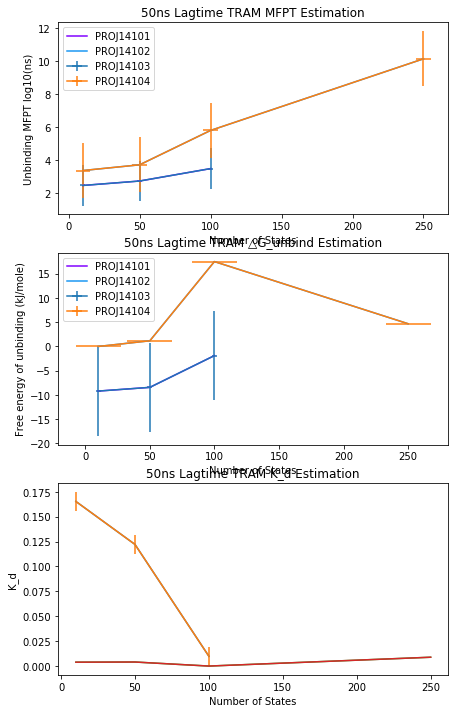

In [26]:
'''Compute and plot TRAM estimates of MFPT, Kd, G_binding'''

projects = ['PROJ14101','PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']
plt.figure(figsize=(7,12))
for project_title in projects:
    tram_mfpts, tram_gbind, tram_kd = [],[],[]
    colors = matplotlib.cm.rainbow(np.linspace(0,1,len(projects)))
    with open('%s/xtc.gro'%project_title) as f:
        line = f.readlines()[-1].strip('\n')
    box_vectors = line.split()
    volume = np.product([float(x) for x in box_vectors]) * 1e-24 # liter
    concentration = 1 / (volume * 6.022e23)
    print('\n\n######## %s ########\nConc: %.4f M'%(project_title, concentration))

    for n_clusters in [10,50,100,250]: #,500,750,1000,2500]: #[10,50,100,250,500,750,1000,2500]:
        try:
            cluster_features = np.load('%s/bootstrap/tica_%d_0/cluster_features.npy'%(
                project_title, n_clusters))
            cluster_distances = [np.sum(cluster_features[x]) / np.shape(cluster_features[x]
                )[0] for x in range(len(cluster_features))]
            for method in ['tram']:
                bootstrap_count = 10
                msm_objs = [np.load('%s/bootstrap/%s_%d_%d/msm_obj.npy'%(
                    project_title, method, n_clusters, x), allow_pickle=True).item()
                           for x in range(bootstrap_count)]
                populations = [np.load('%s/bootstrap/%s_%d_%d/stat_dist.npy'%(
                    project_title, method, n_clusters, x), allow_pickle=True)
                           for x in range(bootstrap_count)]
                transition_mats = [np.load('%s/bootstrap/%s_%d_%d/transition_matrix.npy'%(
                    project_title, method, n_clusters, x), allow_pickle=True)
                           for x in range(bootstrap_count)]
                bound_states = [[x for x in range(len(cluster_distances)
                    ) if cluster_distances[x] < 1.5 and x in msm_obj.active_set]
                        for msm_obj in msm_objs]
                unbound_states = [[x for x in range(len(cluster_distances)
                    ) if cluster_distances[x] > 5.0 and x in msm_obj.active_set]
                        for msm_obj in msm_objs]
                bound_states = [[np.where(msm_objs[y].active_set == x
                        )[0][0] for x in bound_states[y]]
                        for y in range(len(msm_objs))]
                unbound_states = [[np.where(msm_objs[y].active_set == x
                        )[0][0] for x in unbound_states[y]]
                        for y in range(len(msm_objs))]
                bound_pop = [np.sum([populations[y][x] for x in bound_states[y]]) for y in range(
                    len(bound_states))]
                unbound_pop = [np.sum([populations[y][x] for x in unbound_states[y]]
                    ) for y in range(len(unbound_states))]
                print('\n%s with %d states MFPT of unbinding:'%(method, n_clusters))
                _mfpts = [msm_objs[x].mfpt(bound_states[x], unbound_states[x]) for x in range(
                    len(msm_objs))]
                print(np.average(_mfpts))
                print('Results computed from [%d,%d] bound, unbound states respectively,'%(
                    len(bound_states), len(unbound_states)))
                print('With bound, unbound populations of [%.3f,%.3f]'%(
                    np.average(bound_pop)*100, np.average(unbound_pop)*100))
                k_d = [unbound_pop[x]**2/bound_pop[x] for x in range(len(unbound_pop))]
                g_bind = [-0.008314*300.*np.log(k_d[x]/concentration) for x in range(
                    bootstrap_count)]
                if method == 'tram':
                    tram_mfpts.append([n_clusters,np.average(_mfpts)])
                    tram_gbind.append([n_clusters,np.average(g_bind)])
                    tram_kd.append([n_clusters,np.average(k_d)])
        except Exception as e:
            print(e)
            pass


    plt.subplot(311)
    tram_mfpts = np.asarray(tram_mfpts)
    print(tram_mfpts[:,0])
    print(tram_mfpts[:,1])
    plt.plot(tram_mfpts[:,0], np.log10(tram_mfpts[:,1]), color=colors[projects.index(project_title)])
    plt.errorbar(tram_mfpts[:,0], np.log10(tram_mfpts[:,1]),
        min(np.log10(tram_mfpts[:,1]))/2, max(np.log10(tram_mfpts[:,1]))/2)
#    plt.ylim(1,10)
    plt.xlabel('Number of States')
    plt.ylabel('Unbinding MFPT log10(ns)')
    plt.title('50ns Lagtime TRAM MFPT Estimation')
    plt.legend(projects)
    plt.subplot(312)
    tram_gbind = np.asarray(tram_gbind)
    plt.plot(tram_gbind[:,0], tram_gbind[:,1], color=colors[projects.index(project_title)])
    plt.errorbar(tram_gbind[:,0], tram_gbind[:,1],
        min((tram_gbind[:,1])), max(tram_gbind[:,1]))
    #plt.ylim(0,60)
    plt.xlabel('Number of States')
    plt.ylabel('Free energy of unbinding (kJ/mole)')
    plt.title('50ns Lagtime TRAM △G_unbind Estimation')
    plt.legend(projects)
    plt.subplot(313)
    tram_kd = np.asarray(tram_kd)
    plt.plot(tram_kd[:,0], tram_kd[:,1], label=project_title)
#            color=colors[projects.index(project_title)],
    plt.errorbar(tram_kd[:,0], tram_kd[:,1],
        min((tram_kd[:,1])), max(tram_kd[:,1]))
    #plt.ylim(0,0.5)
    plt.xlabel('Number of States')
    plt.ylabel('K_d')
    plt.title('50ns Lagtime TRAM K_d Estimation')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()



4.81145804269


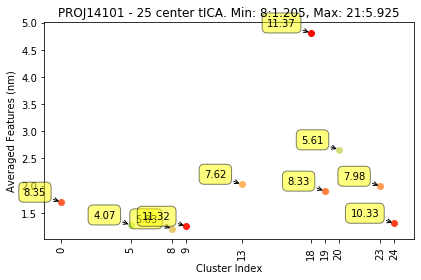

1.21474456787


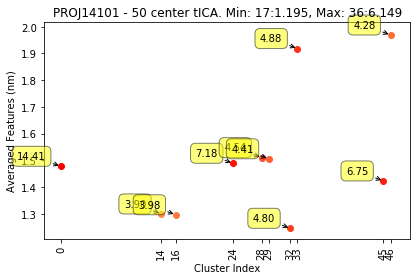

1.46813692365


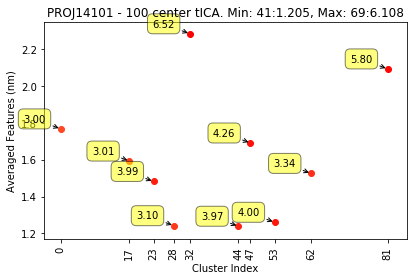

1.55912072318


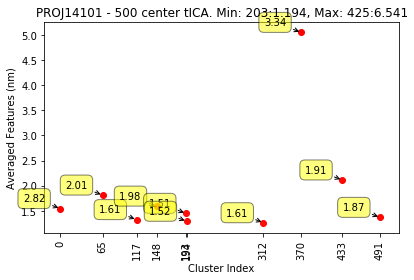

1.59627233233


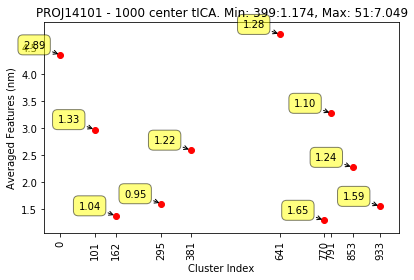

1.81464903695


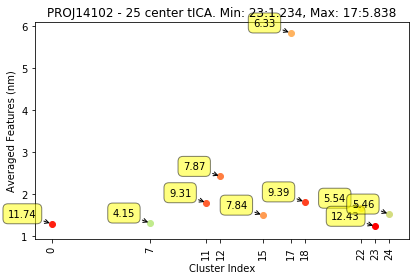

1.40323393685


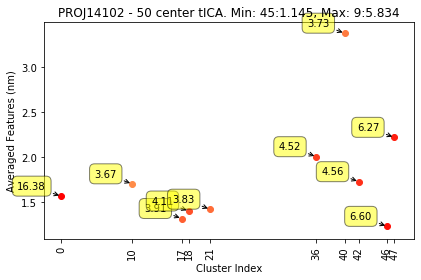

1.97973142351


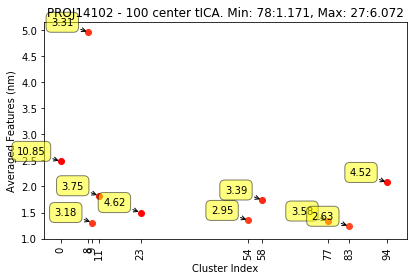

1.76197678702


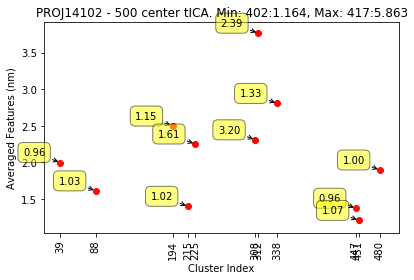

2.49175752912


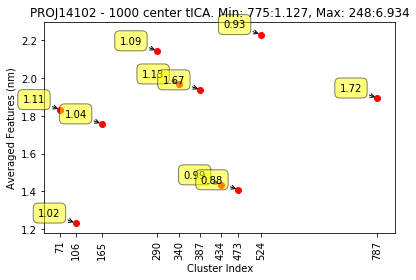

6.12165996007


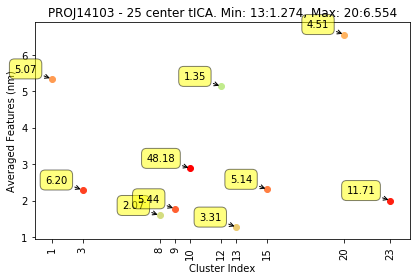

1.95005607605


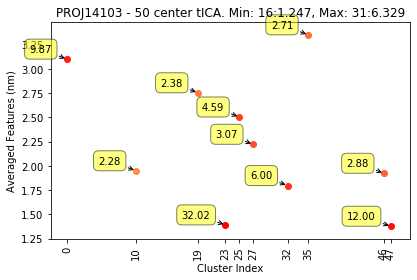

1.54978738512


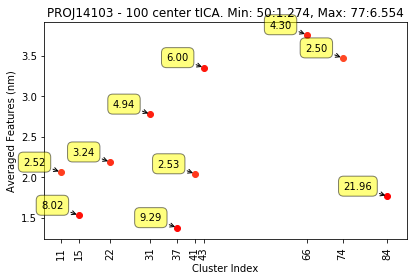

3.20307922363


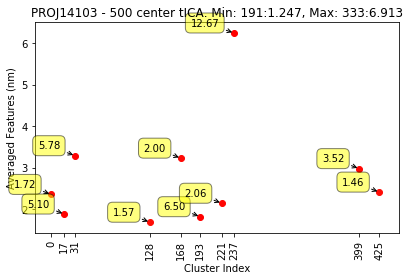

2.05769811358


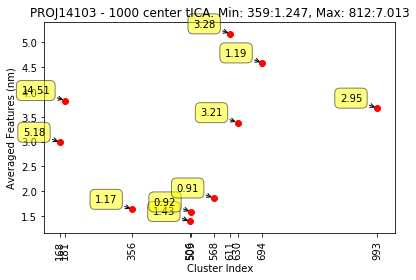

1.95248685564


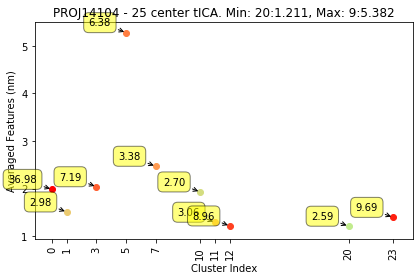

1.97576468331


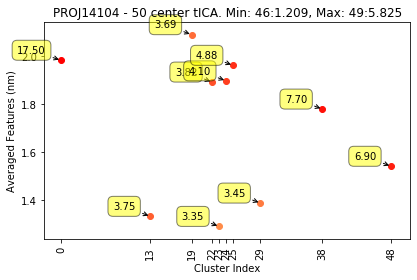

2.18535259792


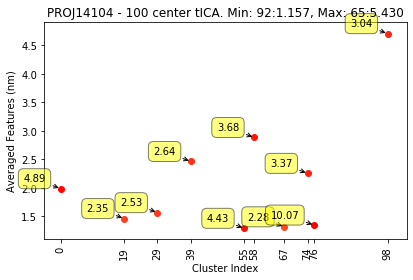

1.82385730743


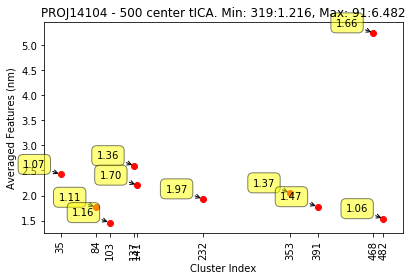

1.37573882512


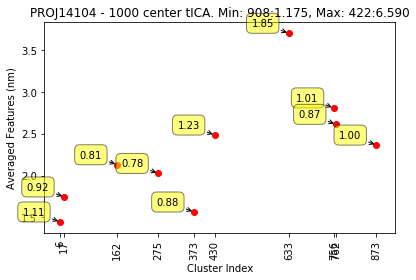

2.15818187169


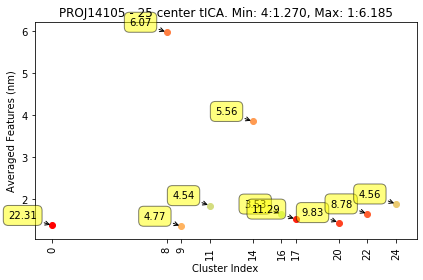

FileNotFoundError: [Errno 2] No such file or directory: 'PROJ14105/tica_50/cluster_features.npy'

In [44]:
"""Plot distances of top 10 populated cluster centers"""

for project_title in ['PROJ14101','PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
    for n_clusters in [25,50,100,500,1000]:
        colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_clusters))
        top_distances = [],[]
        with open('%s/tica_%d/%s_clusters/populations.dat'%(project_title, n_clusters,
            cluster_method), 'r') as f:
            lines = f.readlines()
            populations = [float(x) for x in lines]
        sorted_populations = sorted(populations)
        cluster_features = np.load('%s/tica_%d/cluster_features.npy'%(project_title, n_clusters))
        cluster_distances = [np.sum(cluster_features[x]) / np.shape(cluster_features[x]
            )[0] for x in range(len(cluster_features))]
        top_indices = [x for x in range(len(populations)) if populations[x] in sorted(
            populations)[-10:]]
        top_distances = [cluster_distances[x] for x in range(len(populations)) if populations[x] in sorted(
            populations)[-10:]]
        
        print(cluster_distances[18])
        
        for i in range(len(top_indices)):
            plt.scatter(top_indices[i], top_distances[i],
                color=colors[sorted_populations.index(populations[top_indices[i]])])
        labels = ['%.2f'%(populations[x]*100) for x in range(len(populations)) if x in top_indices]
        for label, x, y in zip(labels, top_indices, top_distances):
            plt.annotate(label, xy=(x, y), xytext=(-15, 15), textcoords = 'offset points', 
              ha='right', va='top', bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
              arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

        plt.title('%s - %d center tICA. Min: %d:%.3f, Max: %d:%.3f'%(project_title, n_clusters, 
            cluster_distances.index(min(cluster_distances)), min(cluster_distances),
            cluster_distances.index(max(cluster_distances)), max(cluster_distances)))
        plt.xticks(top_indices, rotation=90)
        plt.xlabel('Cluster Index')
        plt.ylabel('Averaged Features (nm)')
        plt.tight_layout()
        plt.show()
        plt.savefig('%s/tica_%d/plots/top_cluster_distances.png'%(project_title,n_clusters))
        plt.close()
        
        plt.hist(cluster_distances, bins=25)
        plt.title('%s - %d center tICA'%(project_title, n_clusters))
        #plt.show()
        plt.close()
    

In [11]:
import numpy as np
import sys
%ls
lagtime = 500
comp = 1
for project_title in ['PROJ14101','PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
 #   tica_coordinates = np.concatenate(np.load('%s/tica_%d/tica_coords-lag_%d-comp_%d.npy'%(
 #       project_title,n_clusters,tica_lagtime,n_components)))
    for n_clusters in [25,50,100,500,1000]:
        for method in ['msm','dtram','tram']:
            for lag in [1., 2., 5., 10., 25., 50., 75., 100., 250., 500., 750., 1000.]:

                eigens = np.load('%s/pyemms/%s_%d/eigenvalues_lag_%d.npy'%(project_title,method,
                    n_clusters, int(lag)))
                vamp_2 = np.sum([x**2 for x in eigens])
                print('%s - %s - %d - %d - %.3f' %(project_title, method, n_clusters, lag, vamp_2))

            #right = np.load('%s/%s_%d/right_eigen_lag_%d.npy'%(project_title,method,n_clusters,
            #                lagtime))
            #vec = list(right.T[comp])
            #neg_structure = glob.glob('%s/tica_%d/kcenters_clusters/state_%d*'%(project_title,n_clusters, 
            #        vec.index(min(vec))))
            #pos_structure = glob.glob('%s/tica_%d/kcenters_clusters/state_%d*'%(project_title,n_clusters,
            #        vec.index(max(vec))))
            #print(neg_structure, pos_structure)
            #if neg_structure:
            #    if glob.glob('%s/tica_%d/kcenters_clusters/state_%d*'%(project_title,n_clusters,
            #            vec.index(max(vec)))):
            #        plt.bar(range(len(vec)),vec)
            #        plt.title('%s %s: %d states MIN: %d, MAX: %d'%(project_title,method,n_clusters,
            #            vec.index(min(vec)), vec.index(max(vec))))
            #        plt.show()

actual_10.pdb    do.ipynb*   PROJ14103/  spiroligomer_analysis.ipynb*
actual_1.pdb     ligands/    PROJ14104/  Spiroligomer_VAMPnets.ipynb
analysis.ipynb*  PROJ14101/  PROJ14105/  spiros/
backup.ipynb*    PROJ14102/  PROJ14106/
PROJ14101 - msm - 25 - 1 - 3.459
PROJ14101 - msm - 25 - 2 - 3.459
PROJ14101 - msm - 25 - 5 - 3.459
PROJ14101 - msm - 25 - 10 - 3.459
PROJ14101 - msm - 25 - 25 - 3.459
PROJ14101 - msm - 25 - 50 - 3.459
PROJ14101 - msm - 25 - 75 - 3.459
PROJ14101 - msm - 25 - 100 - 3.459
PROJ14101 - msm - 25 - 250 - 3.459
PROJ14101 - msm - 25 - 500 - 3.459
PROJ14101 - msm - 25 - 750 - 3.459
PROJ14101 - msm - 25 - 1000 - 3.459
PROJ14101 - dtram - 25 - 1 - 4.517
PROJ14101 - dtram - 25 - 2 - 4.517
PROJ14101 - dtram - 25 - 5 - 4.517
PROJ14101 - dtram - 25 - 10 - 4.517
PROJ14101 - dtram - 25 - 25 - 4.517
PROJ14101 - dtram - 25 - 50 - 4.517
PROJ14101 - dtram - 25 - 75 - 4.517
PROJ14101 - dtram - 25 - 100 - 4.517
PROJ14101 - dtram - 25 - 250 - 4.517
PROJ14101 - dtram - 25 - 500 - 4.517
P

FileNotFoundError: [Errno 2] No such file or directory: 'PROJ14101/pyemms/dtram_1000/eigenvalues_lag_1.npy'

In [59]:
for project_title in ['PROJ14101','PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
    structure_file = '%s/xtc.gro'%project_title
    tica_coordinates = np.concatenate(np.load('%s/tica_%d/tica_coords-lag_%d-comp_%d.npy'%(
        project_title,n_clusters,tica_lagtime,n_components)))
    dist = []
    traj_files = []
    for i in range(K):
        feature_files = sorted(glob.glob('%s/features/*R%d_*npy'%(project_title,i)))
        for j in range(len(feature_files)):
            traj_files += re.sub('features/','traj_data/RUN%d/'%i,re.sub(
                'npy','xtc',feature_files[j]))

    for j in tqdm.tqdm_notebook(range(len(traj_files))):
        traj = md.load(traj_files[j], top=structure_file)
        ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
        ligand_COM = compute_center_of_mass(traj,ligand_indices)
        protein_xyz = np.take(traj.xyz, [protein_anchor], axis=1)

        for k in range(len(traj)):
            distance_between_groups = np.sqrt(
                (ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                (ligand_COM[k][2] - protein_xyz[k][0][2])**2)
            dist.append(distance_between_groups)
    plt.figure(figsize=(4,12))
    for i in range(n_components):
        plt.subplot(1,n_components,i)
        print(np.shape(tica_coordinates[:,i]), np.shape(dist))
        plt.scatter(tica_coordinates[:,i][::100],dist[::100])
    plt.xlabel('tIC%d'%i)
    plt.ylabel('Protein-Ligand Distance')
    plt.tight_layout()
    plt.show()
    plt.close()

OSError: No such file: PROJ14101/traj_data/RUN0/P14101_R10_C0.xtc

In [81]:
project_title + # Optimize Model Hyperparameters (GMRQ / VAMP)

lagX,compX,stateX,tica_train,tica_valid,msm_train,msm_valid = [],[],[],[],[],[],[]
states = [10,50,100,500,1000,2500]
n_components = [2,4,6,8,12,16]
training_percentages = [50,75,90]

for training_percentage in training_percentages:
    training_files, validation_files = training_validation_split()
    feature_files = sorted(glob.glob(project_title + '/features/*npy'))
    training_indices = [i for i in range(len(feature_files)) if feature_files[i] in training_files]
    validation_indices = [i for i in range(len(feature_files)) if feature_files[i] in validation_files]
    training_set = [np.load(x) for x in training_files]
    validation_set = [np.load(x) for x in validation_files]

    for i in tqdm.tqdm_notebook(range(len(n_components))): # lagtimes))):
        for j in tqdm.tqdm_notebook(range(len(lagtimes)),leave=False):
            for k in tqdm.tqdm_notebook(range(len(states)),leave=False):
               # for l in tqdm.tqdm_notebook(range(3),leave=False):
                    compX.append(n_components[i])
                    lagX.append(lagtimes[j])
                    stateX.append(states[k])
                    n_clusters = states[k]
                    tica_coordinates = tICA(lag_time=lagtimes[j],
                                           n_components=n_components[i]).fit_transform(training_set + validation_set)
                    training_tica_components = tICA(lag_time=lagtimes[j],
                                           n_components=int(n_components[i])).fit(training_set)
                    tica_train.append(training_tica_components.score(training_set))
                    tica_valid.append(training_tica_components.score(validation_set))
                    clusters = KCenters(n_clusters)
                    assignments = clusters.fit_transform(tica_coordinates)
                    training_assignments = [assignments[x] for x in range(len(assignments)) if x in training_indices]
                    validation_assignments = [assignments[x] for x in range(len(assignments)) if x in validation_indices]
                    msm = MarkovStateModel(n_timescales=n_components[i], lag_time=lagtimes[j], reversible_type='transpose',
                        verbose=False, sliding_window=True, ergodic_cutoff='on')
                    msm.fit(training_assignments)
                    msm_train.append(msm.score(training_assignments))
                    msm_valid.append(msm.score(validation_assignments))

    print('For training percentage: %d:'%training_percentage)
    print('\tBest Score: %.3f'%max(msm_valid))
    print('\tBest Lagtime: %d'%lagX[msm_valid.index(max(msm_valid))])
    print('\tBest Ncomponents: %d'%compX[msm_valid.index(max(msm_valid))])
    print('\tBest Nstates: %d'%stateX[msm_valid.index(max(msm_valid))])
sys.exit(0)


fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
ax1.scatter(tICX,tica_train)
ax1.scatter(tICX,tica_valid)
ax1.set_xlabel('Lagtime (ns)')
ax1.set_ylabel('Score')
ax1.title.set_text('GMRQ tICA Scores')

ax2 = fig.add_subplot(212)
ax2.violinplot(dataset=msm_train,positions=states)
ax2.violinplot(dataset=msm_valid,positions=states)
ax2.set_xlabel('States')
ax2.set_ylabel('Score')
ax2.title.set_text('GMRQ MSM Scores')

#ax3 = fig.add_subplot(223)
#ax3.violinplot(X,CTMSMY)
#ax3.set_xlabel('States')
#ax3.set_ylabel('Score')
#ax3.title.set_text('GMRQ CTMSM Scores')

fig.tight_layout()
fig.show()

# MSM lagtime not allowed as a variable for calculating MSM metric

Training percentage: 11.276 of requested 10


For training percentage: 10:
	Best Score: 13.254
	Best Lagtime: 2
	Best Ncomponents: 16
	Best Nstates: 1000
Training percentage: 26.070 of requested 25


For training percentage: 25:
	Best Score: 13.731
	Best Lagtime: 1
	Best Ncomponents: 16
	Best Nstates: 1000
Training percentage: 51.343 of requested 50


For training percentage: 50:
	Best Score: 13.731
	Best Lagtime: 1
	Best Ncomponents: 16
	Best Nstates: 1000
Training percentage: 75.953 of requested 75


For training percentage: 75:
	Best Score: 14.355
	Best Lagtime: 1
	Best Ncomponents: 16
	Best Nstates: 10
Training percentage: 91.390 of requested 90


For training percentage: 90:
	Best Score: 14.355
	Best Lagtime: 1
	Best Ncomponents: 16
	Best Nstates: 10


SystemExit: 0

In [58]:
# states excluded because of ergotic trimming (if i > j but j !> i, j gets lumped to i)
# d tram can be faster if you calculate free energies first with MBAR and use those as biases
# use state index as bin index for pmf, you will have a pmf for each ensemble, the bias is the pmf
# pmf === free energies
# pyemma has a built-in function for bias with estimate_umbrella_sampling
# don't add extra sample, add extra ensemble with no bias for K=k
# for its error bars do split into a few clones at a time (same amounts of data tho)
# bootstrap for error bars
# these methods help estimate statistical weights for each sample within binned states
# lok at transition matrix, know which states are bound/unbound
# umbrellas won't help you overcome entropic boundaries??
# entropic bottlenecks are very hard to bias on
# do results of GMRQ really match VAMP1?
# bias of tIC1 and scale the bias with a lambda
# project each run over the total tICA plot
# gmrq = what projection onto this basis set gives the slowest dynamics and is statistically robust?
# toof ew statses kinetics way too fast, err on the side of too few to avoid finite sampling problem.
# coarser model leads to better TD, but higher kinetics
# what are timescales from raw MSM
# GMRQ
# do artifacts arise from finit sampling, over coarse-graining, or something else?
# let's take a closer look at the data via raw MSMs...
#overlap matrix, minimize diagonal entries, maximize off-diagonal
# train/validation split

# kinetics  TD  states  Model  data included
#  good     bad  100     tram      all
# etc.

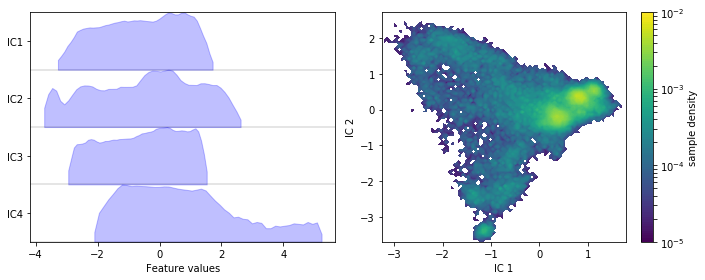

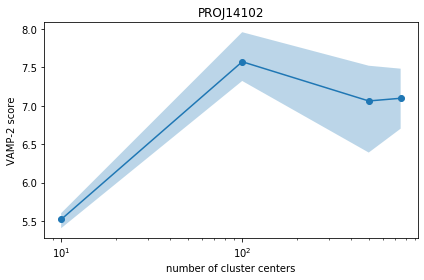

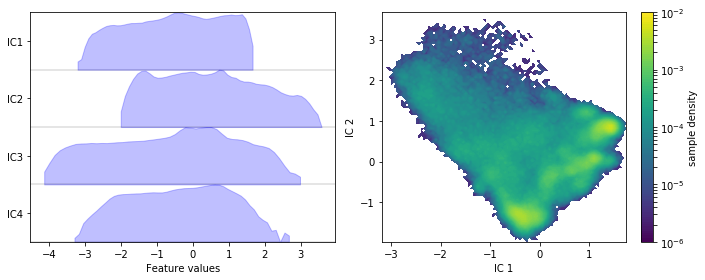

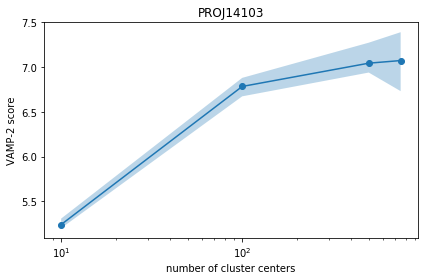

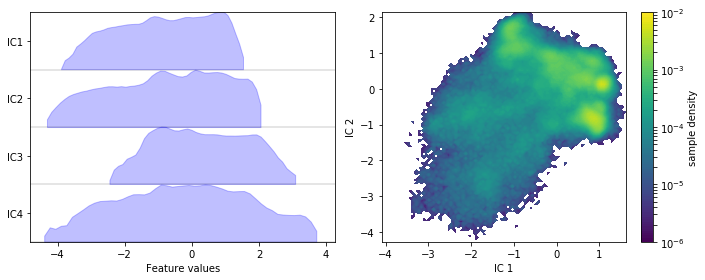

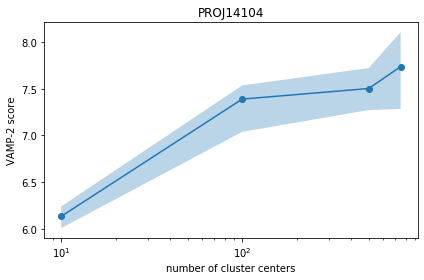

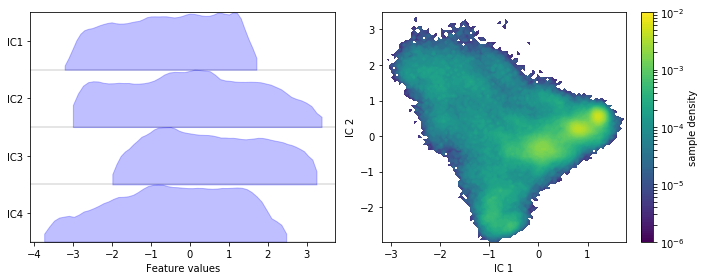

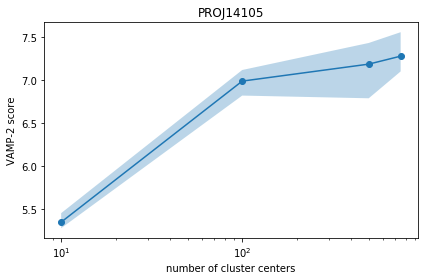

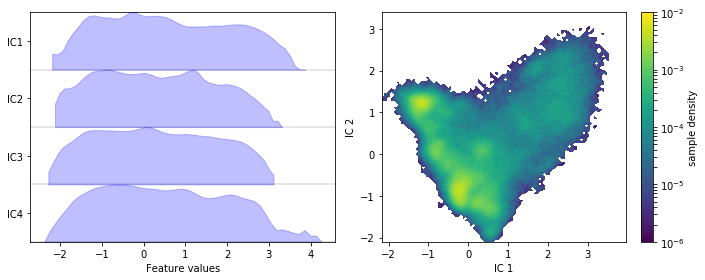

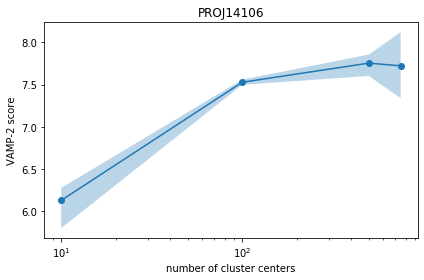

In [11]:
import pyemma

project_title = 'PROJ14101'
for project_title in ['PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
    feature_files = []
    for i in range(runs):
        feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
    features = [ np.load(filename) for filename in feature_files]

    tica = pyemma.coordinates.tica(features, lag=5, dim=4)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    pyemma.plots.plot_feature_histograms(
        tica_concatenated,
        ax=axes[0],
        feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
        ylog=True)
    pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
    axes[1].set_xlabel('IC 1')
    axes[1].set_ylabel('IC 2')
    fig.tight_layout()

    n_clustercenters = [10,100,500,750] #[10, 100, 500, 1000]

    scores = np.zeros((len(n_clustercenters), 5))
    for n, k in tqdm.tqdm_notebook(enumerate(n_clustercenters)):
        for m in range(5):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=500, stride=1)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, lag=40)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

    fig, ax = plt.subplots()
    lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
    ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
    ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
    ax.semilogx()
    ax.set_title(project_title)
    ax.set_xlabel('number of cluster centers')
    ax.set_ylabel('VAMP-2 score')
    fig.tight_layout()

In [ ]:
import pyemma, glob
import numpy as np
project_title = 'PROJ14101'
runs = 20

for project_title in ['PROJ14102','PROJ14103','PROJ14104','PROJ14105','PROJ14106']:
    active_counts, active_states = 0,0
    print(project_title)
    if not os.path.exists('%s/pyemma'%project_title):
        os.mkdir('%s/pyemma'%project_title)
    feature_files = []
    for i in range(runs):
        feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
    features = [ np.load(filename) for filename in feature_files]

    tica = pyemma.coordinates.tica(features, lag=5, dim=4)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    while [active_counts, active_states] != [1.0,1.0]:
        clusters = pyemma.coordinates.cluster_kmeans(tica_output, k=500, max_iter=1000, stride=1)
        dt = md_time_step*stride*1000
        its = pyemma.msm.its(clusters.dtrajs, lags=150, nits=8, errors='bayes')
        pyemma.plots.plot_implied_timescales(its, units='ps', dt=dt)
        msm_obj = pyemma.msm.estimate_markov_model(clusters.dtrajs, lag=35, dt_traj='%f ps'%dt)
        print(msm_obj.active_count_fraction, msm_obj.active_state_fraction)
        active_counts, active_states = msm_obj.active_count_fraction,msm_obj.active_state_fraction
    np.save('%s/pyemma/tica_crd.npy'%project_title,tica_output)

PROJ14102


0.9993637082313017 0.996


0.9992673003875595 0.994


0.9993444266625533 0.996


0.9995179607812892 0.996


0.9993444266625533 0.996


0.9972234541002256 0.98


0.999556523918786 0.998


0.999421552937547 0.996


0.9963750650752945 0.978


0.9993637082313017 0.994


0.998573163912616 0.994


0.9971848909627288 0.982


0.9963557835065461 0.978


0.998573163912616 0.992


0.9993444266625533 0.996


0.9989395137188362 0.994


0.9993058635250563 0.994


1.0
1.0
09-09-19 21:38:33 pyemma._base.serialization.h5file INFO     overwriting model "default" in file PROJ14101/msm/msm1.h5


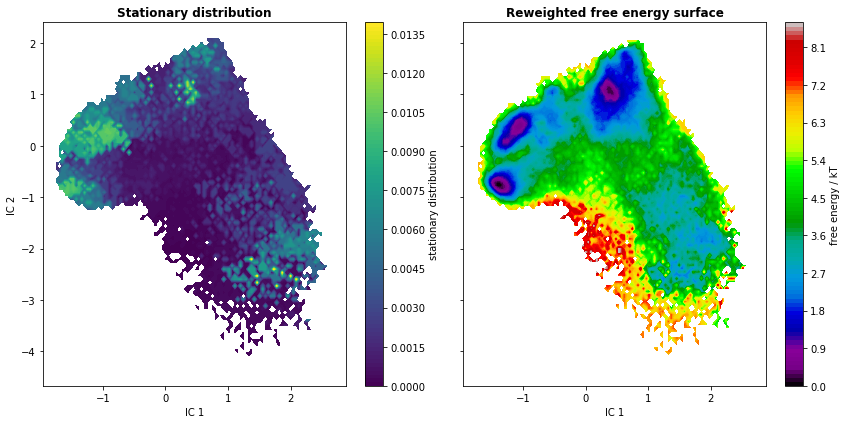

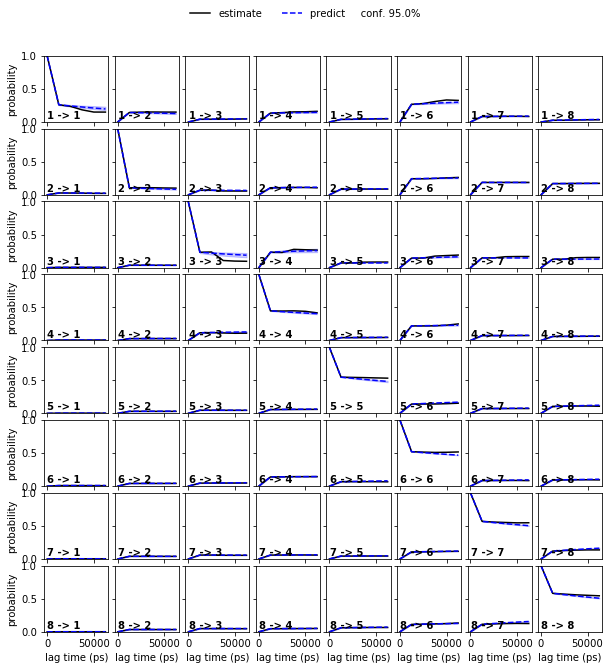

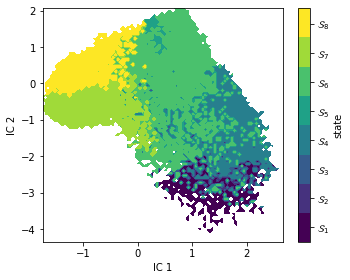

In [16]:
if not os.path.exists('%s/msm'%project_title):
    os.mkdir('%s/msm'%project_title)
    
msm.save('%s/msm/msm_notbayes1.h5'%project_title, overwrite=True)
dtrajs_concatenated = np.concatenate(clusters.dtrajs)
nstates = 8

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=dt, units='ps')

dtrajs_concatenated = np.concatenate(clusters.dtrajs)
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()

2
3
4


(<Figure size 864x632.498 with 1 Axes>, array([[ 0.        ,  0.73205843],
        [ 0.37910114,  0.20086967],
        [ 0.62063571,  0.53082469],
        [ 1.        ,  0.        ]]))

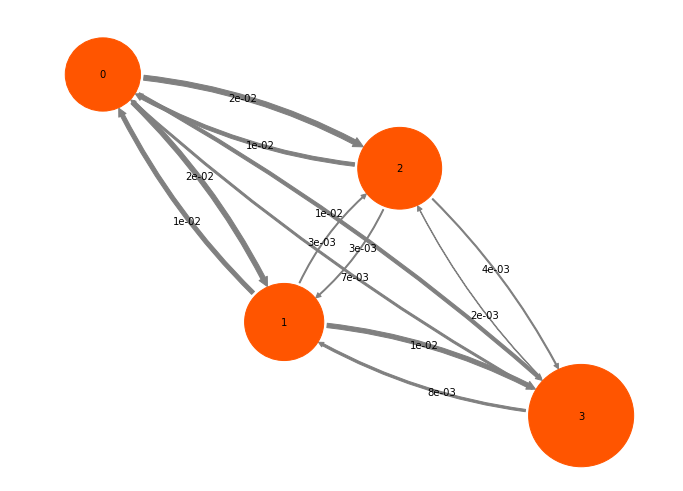

In [25]:
for states in tqdm.tqdm_notebook([2,3,4,5,6,7,8]):
    count = 0
    pcca_obj = pyemma.msm.PCCA(msm_obj.P,states)
    a = pcca_obj.coarse_grained_transition_matrix
    for i in range(len(a)):
        for j in range(len(a[i])):
            if a[i][j] < 0:
                count += 1
    if count == 0:
        print(states)

pcca_obj = pyemma.msm.PCCA(msm_obj.P,4)
a = pcca_obj.coarse_grained_transition_matrix
pyemma.plots.plot_markov_model(a)

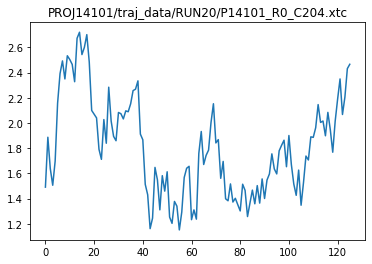

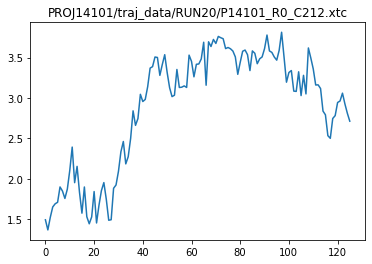

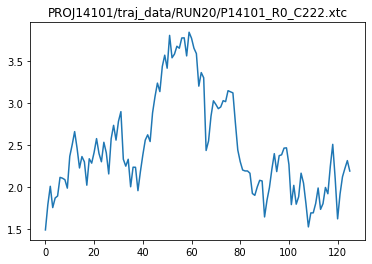

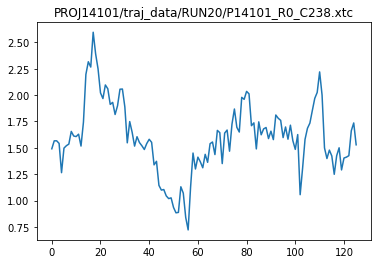

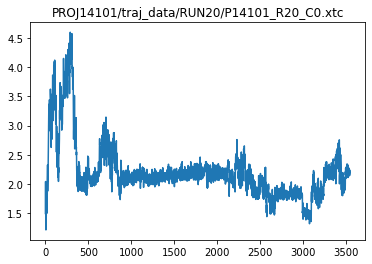

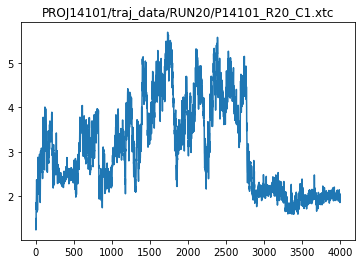

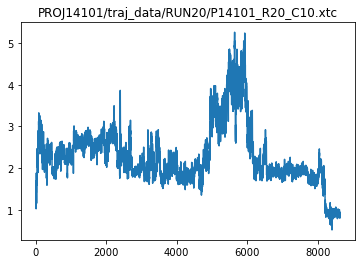

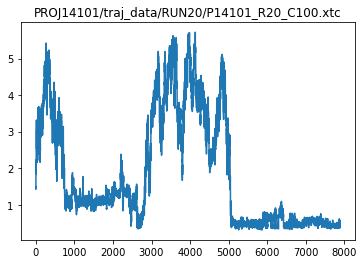

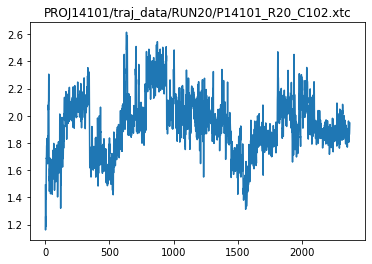

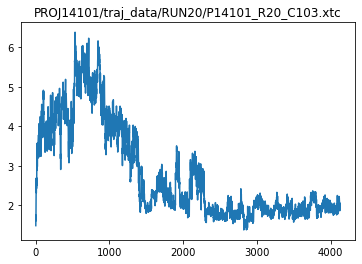

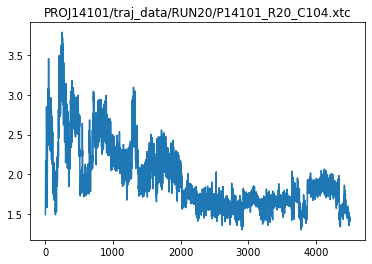

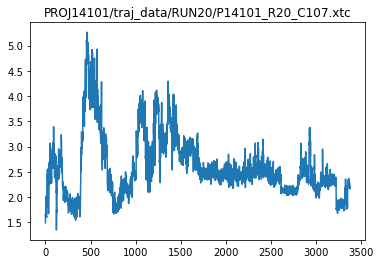

KeyboardInterrupt: 

In [23]:
i=0
traj_files = []
project_title = 'PROJ14101'
indices = [[574,1493]]
traj_files += sorted(glob.glob(project_title + '/traj_data/RUN20/*xtc'))

for traj_file in tqdm.tqdm_notebook(traj_files):
    traj = md.load(traj_file,top='%s/xtc.gro'%project_title)
    dist = list(md.compute_distances(traj,indices))
    if max(dist) > 2.5:
        plt.figure(i)
        plt.plot(range(len(dist)),dist)
        plt.title(traj_file)
        plt.show()
        plt.close()
        i += 1

In [1]:
def compute_vamp_score():

    training_percentage = 50
    train_scores, validation_scores, conditions = [],[],[]
    training_set, validation_set = training_validation_split(training_percentage)
    training_set = [np.load(x) for x in training_set]
    validation_set = [np.load(x) for x in validation_set]
    model = Pipeline([
        ('tica', tICA(kinetic_mapping=True)), 
        ('cluster', KMeans()), 
        ('msm', MarkovStateModel(lag_time=16, n_timescales=3, verbose=False))])
    for lag in [1,2,4,8,16,32,64,128]:
        for n_clusters in [10,50,100,250,500,1000]:
            for comp in [2,4,6,8]:
                model.set_params(cluster__n_clusters=n_clusters, tica__lag_time=lag, tica__n_components=comp)
                try:
                    model.fit(training_set)

                    train_score = model.score(training_set)
                    test_score = model.score(validation_set)

                    msm_timescales = model.named_steps['msm'].timescales_
                    pr = model.named_steps['msm'].percent_retained_

                    print('clusters lag components train test', n_clusters, lag, comp, train_score, test_score)
                    results.append({
                        'train_score': train_score,
                        'test_score': test_score,
                        'n_clusters': n_clusters,
                        'components': comp,
                        'msm_timescale0': msm_timescales[0],
                        'msm_timescale1': msm_timescales[1],
                        'percent_retained' : pr,
                        'tica_lag': lag,
                        'fold': fold
                     })
                except Exception as e:
                    print(e)
        
    results_data = pd.DataFrame(results)
    print(results_data.head())
    #results_data.to_pickle('gmrq_try10.pickl')
    return results_data

project_title = 'PROJ14101'
compute_vamp_score()

ModuleNotFoundError: No module named 'napari'

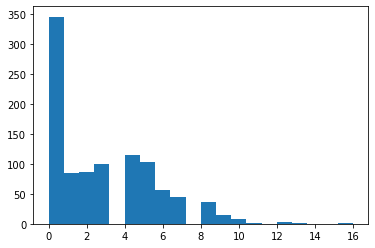

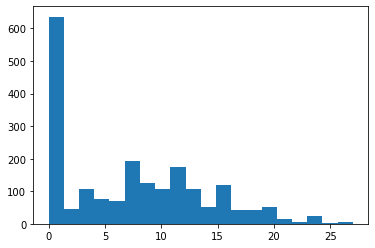

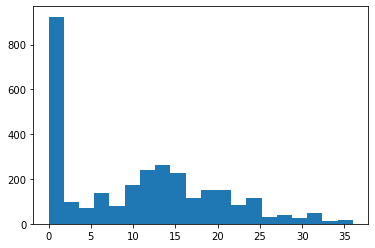

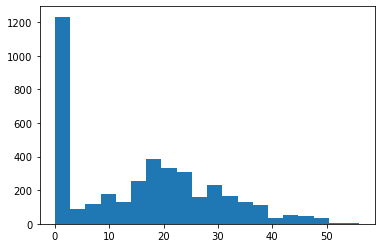

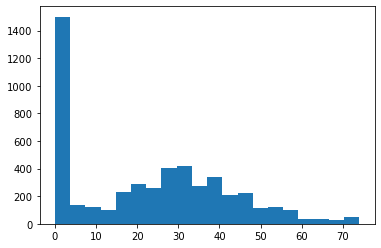

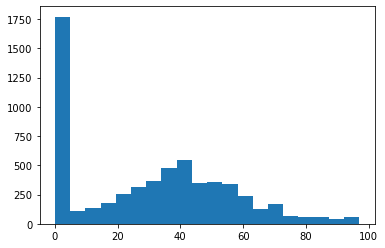

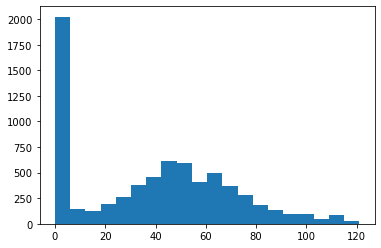

In [4]:
import mdtraj as md
import glob, itertools
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

custom_residues = ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A'] # for spiroligomers

structure_files = glob.glob('/media/tug27224/methuselah/analysis/PROJ14101/tica_1000_0/kcenters_clusters/*pdb')
structures = [md.load(x) for x in structure_files]
protein_indices = list(set([a.residue.index for a in structures[0].topology.atoms if a.element.symbol !='H' and a.residue.name not in custom_residues]))
ligand_indices = list(set([a.residue.index for a in structures[0].topology.atoms if a.element.symbol !='H'and a.residue.name in custom_residues]))
pairs = list(itertools.product(protein_indices,ligand_indices))
contacts = []

for cutoff in [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]:
    for i in structures:
        contacts.append(md.compute_contacts(i, pairs))
    contact_counts = []
    for i in contacts:
        contact_counts.append(len(np.where(i[0][0] < cutoff)[0]))

    plt.hist(contact_counts, bins=20)
    plt.show()
    plt.close()
